# eICU-CRD

All stays are centered on ICU admission (unlike MIMIC). 

<u>Data in the eICU-CRD database was collected from several hospitals.</u>

Access to the database was done through Physionet, by signing the data use agreement, as certification and credentials were already obtained for MIMIC-IV.

**<center>The following was ran and obtained on Google BigQuery.</center>**

The database has schema documentation: https://eicu-crd.mit.edu/eicutables/patient/

In [227]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [275]:
%run textColumn_analysis.ipynb

## Overview of the data

|  | feature name | Value |
| --- | ----------- | ----------- |
| Number of ICU stays (one patient can go through several ICUs) | `patientunitstayid` | 200 859 |
| Number of distinct hospital admissions$^*$ | `patienthealthsystemstayid` | 166 355 |
| Number of distinct ICU patients | `uniquepid` | 139 367 |

<br>

One `uniquepid` can be associated with several rows in the _patient_ table; but patients are uniquely identified by `uniquepid`. A total of **139 367** unique patient are registered with ICU stays in the database. 

One hospital stay is identified by `patienthealthsystemstayid`, and a patient with several admissions can thus have several `patienthealthsystemstayid`'s. A total of **166 355** hospital stays (uniquepid-patienthealthsystemstayid unique pair) are recorded in the database. 

Finally, over one hospital stay, a patient can transfer ICU unit; each stay in an ICU unit is uniquely identified by a `patientunitstayid`.

In [ ]:
% sql

SELECT COUNT(DISTINCT uniquepid),
  COUNT(DISTINCT patienthealthsystemstayid),
  COUNT(DISTINCT patientunitstayid)
FROM `physionet-data.eicu_crd.patient`

- the number of hospital admissions per patient ranges from **1** to **24**, with an average of **1.2** hospital stay per patient. 
- the average number of unit stay per patient and per hospital admission (`uniquepid`-`patienthealthsystemstayid` pair) ranges from **1** to **17**, with an average of **1.2** ICU stay. **83.39%** of the patients stays in hospital are only associated with one ICU admission, **13.92%** with 2 ICU stays.

In [ ]:
% sql

# number of ICU stays per patient (this groups over patientunitstayid)
SELECT uniquepid, patienthealthsystemstayid, COUNT(*) 
FROM `physionet-data.eicu_crd.patient`
GROUP BY uniquepid, patienthealthsystemstayid
ORDER BY uniquepid

# with result from previous query
# we compute the number of hospital stay per patient
SELECT uniquepid, COUNT(*) AS c 
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonf7ee68c06e5a782a68d3c6ffdea5f04bbc330bcf3e956f084b8faff7c3db06ac`
GROUP BY uniquepid
ORDER BY c DESC 

# with result from previous query
# we compute the average number of hospital stay per patient
SELECT AVG(c)
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon15676a1cd443f1cb799184faeb01dc33c9219b7474737cf39405e6d1e8514afc`

**Here we select the list of distinct patient and hospital stay** (one patient can have several hospital stays, and one hospital stay is <u>minimum</u> one ICU stay)

In [ ]:
% sql
SELECT DISTINCT uniquepid, patienthealthsystemstayid
FROM `physionet-data.eicu_crd.patient`

- `hospitaldischargeoffset` is never null. It corresponds to the number of minutes between hospital admission and hospital discharge
- average length of stay is **9763.67** minutes, or **6.78** fractional days.

In [ ]:
% sql

# count of null hospitaldischargeoffset
SELECT DISTINCT ordercategoryname FROM `physionet-data.mimiciv_3_1_icu.procedureevents`

# average length of stay
SELECT AVG(hospitaldischargeoffset) FROM `physionet-data.eicu_crd.patient`

## Patients representation

Since the _patient_ table encompasses all distinct patient, hospital stays and ICU stays, we don't perform demographic statistics for all ICU stays but rather over distinct patient-stay (`uniquepid`-`patienthealthsystemstayid` pair). For example, for `age`, the age of the patient can change from one admission to the other.

**<u>Age</u>**

Because the patient information is recorded everytime the patient is admitted in ICU, we can take the age distribution of patients as they are admitted to ICU (unlike in MIMIC-IV)

- **!!** In _patient_, `age` is a string (documentation indicates VARCHAR(10)). Null age is indicated by an empty string "" and represents only **0.05%** of the database. Patient that are more than **89** years old have age equal to "> 89" (for de-identification purposes) and represent **3.53%** of the rows. 
- Similarly, null `gender` is actually an empty string "", which represents **0.07%** of the rows. **0.017%** of the rows have "Unknown" gender
- Null `ethnicity` is an empty string as well, for **1.14%** of the rows. "Other/unknown" is **4.75%** of the rows

In [ ]:
% sql

# percentage of null age in patient
SELECT 100*COUNT(*)/(SELECT COUNT(*) FROM `physionet-data.eicu_crd.patient`)
FROM `physionet-data.eicu_crd.patient`
WHERE age IS NULL 

# average excluding null age and above 89
# because age is a string we must cast it as an integer
SELECT AVG(CAST(age AS int))
FROM `physionet-data.eicu_crd.patient`
WHERE age != "" AND age != "> 89"

- The first query returns 166 355 rows, indicating that there is no inconsistency of age accross ICU stays

To look at age distribution, we only consider hospital stays (and not disinct patients only), as a patient that comes several times can be aged differently at his different hospital admissions.

- **0.05%** have null age (empty string), **3.66%** have age equal to "> 89". 
- **0.286%** or **476** patients are under 18.

In [ ]:
% sql

# count the number of patient-age tuples
SELECT DISTINCT uniquepid, patienthealthsystemstayid, age
FROM `physionet-data.eicu_crd.patient`

# with result from above query
# age and their frequency in hospital admissions 
SELECT age, 100*COUNT(*)/166355 AS percentage
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonad2aaa39d778090a55f706a0ab88f191af1dae7270a5eb9c33bfaea516829ead`
GROUP BY age

# frequencies of childrens 
SELECT * 
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonad2aaa39d778090a55f706a0ab88f191af1dae7270a5eb9c33bfaea516829ead` 
WHERE age != "" 
  AND age != "> 89"
  AND CAST(age AS int) < 18

Instead of computing age statistic by removing "> 89", we replace it with "89" to have a better approximate of the average age.

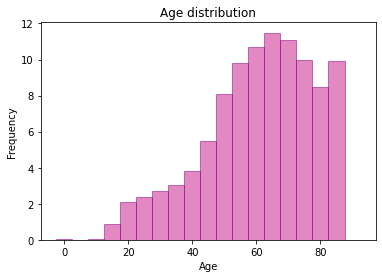

In [397]:
df_patient_age = pd.read_csv("../Data/eICU-CRD/patient_age_count.csv")

# here we add the "> 89" percentage to the "89" value and we remove the last row
row = { "age": "89", "percentage": df_patient_age["percentage"].loc[90]+df_patient_age["percentage"].loc[91] }
df_patient_age.loc[90] = row
df_patient_age = df_patient_age.drop([91])

# first we group ages by 5 and compute their associated frequency
bins = np.linspace(0,90,19)
count = [0 for i in range(19)]

for index, datapoint in df_patient_age.dropna().iterrows() :
    count[int(datapoint["age"])//5] += datapoint["percentage"]

plt.bar(bins, count, width=5, edgecolor='darkmagenta', color='mediumvioletred', alpha=0.5)
plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

In [407]:
df_age_int = df_patient_age.dropna() 

# from this we can re-compute age average:
avg_age = 0
for index, datapoint in df_age_int.iterrows() :
    df_age_int.loc[index, "age"] = int(df_age_int.loc[index, "age"])
    avg_age += datapoint["percentage"]*int(datapoint["age"])
avg_age = avg_age/len(df_age_int)
print("Average age in eICU-CRD couting all patient > 89 as 89 is", avg_age)

df_minors = df_age_int["percentage"].loc[ df_age_int["age"] < 18 ]
df_minors
print("The percentage of childrens is", sum( df_age_int["percentage"].loc[ df_age_int["age"] < 18 ]))

Average age in eICU-CRD couting all patient > 89 as 89 is 69.83285410384089
The percentage of childrens is 0.2861350725857345


**<u>Gender</u>**



In [ ]:
% sql

# gender and their frequency in patient across all ICU stays
SELECT gender, 100*COUNT(*)/(SELECT COUNT(*) FROM `physionet-data.eicu_crd.patient`)
FROM `physionet-data.eicu_crd.patient`
GROUP BY gender

- The first query returns 166 355, which is extacly the number of unique hospital stays; thus there is no inconsistency in the gender indicated in the database across ICU stays 
- However when grouping by `uniquepid`-`gender`, we obtain **139 393**, so there are **26** inconsistencies between the patient and their gender. All of these inconsistencies except for 004-5716, 017-11051, 027-150454, 031-2559 (male-female) and 032-30969 (male-other) correspond to null values, but as they are recorded several times in the database, we still have ther rows indicating their gender. These 26 patients are associated with **84** hosital admissions, which corresponds to 0.05%. <u>We consider this as neglectable and we proceed to statistics on gender</u>.

`list_gender_inconsistency` is the list of all `uniquepid` with a gender inconsistency.


- When taking several hospital admissions into account (_if a women is admitted twice to the hospital, then we count twice her gender as a woman_), we have **53.75%** of men, **46.17%** of women, **0.07%** of null (empty string), **0.02** of "Unknown" and less than 0.01% for "Other"
- when taking gender of distinct patients, removign the 26 patients that have erroneous genders (so across 139 367 distinct patients that have been at least once in ICU), we have **53.95%** of men, **45.95%** of women, **0.07%** of null (empty string), **0.02%** of "Unknown" and  less than 0.01% for "Other"

In [ ]:
% sql 

# query 1)
# gender of patients in hospitalk admissions across stays is the same across icu stays
SELECT DISTINCT uniquepid, patienthealthsystemstayid, gender
FROM `physionet-data.eicu_crd.patient` 

# query 2)
# with table from above query
# we check the consistency of gender across admissions
# the number of rows in result table is bigger than the number of patients
SELECT DISTINCT uniquepid, gender 
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon6ea4126e36c78fd6853dd8c25adbdeacf70a19a9f587f778dbbd1e7d30d14378`

# from query 1, we obtain the different genders and their frequency 
# across hospital admissions (not across patients)
SELECT gender, COUNT(*)/(SELECT COUNT(*) FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon6ea4126e36c78fd6853dd8c25adbdeacf70a19a9f587f778dbbd1e7d30d14378`)
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon6ea4126e36c78fd6853dd8c25adbdeacf70a19a9f587f778dbbd1e7d30d14378`
GROUP BY gender

# with result table from query 2
# we obtain the patients that appear with different genders
SELECT uniquepid, COUNT(*) AS c 
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anone8e87d2ca14103b09cb0fc1c4bd87d1605d1766ab703e11559736224f2aec29e`
GROUP BY uniquepid
HAVING c > 1

# here we select the unique patients and their gender
# for all patients that do not appear with several gender indications
SELECT * 
FROM (
  SELECT DISTINCT uniquepid, gender
  FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon6ea4126e36c78fd6853dd8c25adbdeacf70a19a9f587f778dbbd1e7d30d1437`
) A 
LEFT JOIN `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anone98af1379df5cff9f82fb11058a3518f4c92cc80a683b3b0012c087869fb0e1f` B
ON A.uniquepid=B.uniquepid
WHERE B.uniquepid IS NULL
# from the result of this query, we obtain the percentage of genders

In [231]:
# the uniquepid with gender inconsistencies
list_gender_inconsistency = [
    "002-50226","002-66204","003-44255","004-12627","004-18621",
    "004-42773","004-5716","004-72315","004-86879","008-20478",
    "008-5728","009-16546","009-7445","017-11051","017-1482",
    "017-59827","017-73098","017-90100","021-144703","024-4709",
    "027-150454","027-165386","027-97252","031-2559","032-30969","004-93515",
]

`age` distribution per `gender`. By only selecting "Female" and "Male" we obtain the histogram for 160 132 rows. Then we select the rows for which the gender is "Other" but we don't take into account the rows for which the gender is an empty string or "unknown". Again, we also remove the rows for age "> 89".

In [236]:
df_age_gender = pd.read_csv("../Data/eICU-CRD/patient-admission_age_gender.csv")
F = pd.DataFrame(df_age_gender.loc[ (df_age_gender["gender"]=="Female")&(df_age_gender["age"]!="> 89") ]["age"]).dropna()
M = pd.DataFrame(df_age_gender.loc[ (df_age_gender["gender"]=="Male")&(df_age_gender["age"]!="> 89") ]["age"]).dropna()
O = df_age_gender.loc[ (df_age_gender["gender"]=="Other") ].dropna()
F["age"]=pd.to_numeric(F['age'])
M["age"]=pd.to_numeric(M['age'])

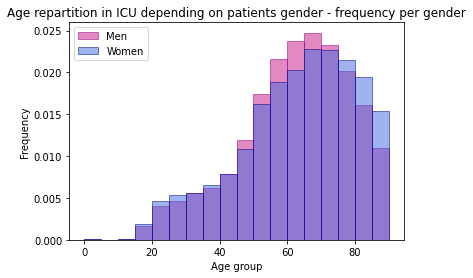

In [237]:
bins = np.linspace(0,90, 19)
plt.hist(M["age"], bins=bins, label="Men", edgecolor='darkmagenta', color='mediumvioletred', alpha=0.5, density=True)
plt.hist(F["age"], bins=bins, label="Women", edgecolor='navy', color='royalblue', alpha=0.5, density=True)
plt.legend()
plt.xlabel("Age group")
plt.ylabel("Frequency")
plt.title("Age repartition in ICU depending on patients gender - frequency per gender")
plt.show()

### <u>patient</u> 

**200 859** rows, which correspond to **200 859** ICU admissions.

<u>Primary key of _patient_:</u> `patientunitstayid` identifies unit stays. It is the main key for linking data to a unit stay across all tables. 


**<u>Ethnicity</u>**

- First we look at the `ethnicity` of the distinct patients. However the query results in **140 100 rows**: **22** patients have 3 different ethinicities indicated (_it might correspond to more rows than 3, for example if a patient is indicated twice a Caucasian, once as hispanic and once as unknown_), and **689** patients have 2 ethnicities indicated. Among these errors, only 107 correspond to an ethnicity indication + a null value; the rest indicates two different ethnicities (_ex: Hispanic and Caucasian_), which may include "Other/unknown". 

- To compute ethnicity frequency, we first remove all 711 patients from the list of distinct patients, which gives **138 656** distinct patients. 
- Then we compute the race frequency accross admissions rather than patients: a caucasian patient admitted twice will count twice towards the frequency. We first remove all rows associated with patients that have several ethnicities indicated, we obtain **164 438** rows. 

In [ ]:
% sql

# distinct patient-ethnicity tuples
# if no problem, this should result in the same number of rows as the number of patients
# but higher number of resulting rows
SELECT DISTINCT uniquepid, ethnicity
FROM `physionet-data.eicu_crd.patient`

# query 2)
# with result from above query
# number of ethnicities registered per patient
SELECT uniquepid, COUNT(*) AS co
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon910e5217904cd318d4511da40a5214bfb2d8fa52b046850cbcabd0e9392256c1`
GROUP BY uniquepid
ORDER BY co DESC

# with result from above query
# in the subquery we select the patients that have several ethnicities indicated
# we get all patient and their different ethinicities when inconsistencies
SELECT DISTINCT P.uniquepid, P.ethnicity
FROM `physionet-data.eicu_crd.patient` P
LEFT JOIN (
  SELECT uniquepid 
  FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anona50aa284e19f32a351e1f53a3064a987b4a83d4d1c141af7cf82e01bad1f37eb` 
  WHERE co > 1) E
ON P.uniquepid=E.uniquepid
WHERE E.uniquepid IS NULL 
ORDER BY uniquepid

# with table from query 2
# this query returns all patient and their ethnicity that are consistent
SELECT P.uniquepid, P.ethnicity
FROM (SELECT DISTINCT uniquepid, patienthealthsystemstayid,ethnicity FROM `physionet-data.eicu_crd.patient`) P
LEFT JOIN (
  SELECT uniquepid 
  FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anona50aa284e19f32a351e1f53a3064a987b4a83d4d1c141af7cf82e01bad1f37eb` 
  WHERE co > 1) E
ON P.uniquepid=E.uniquepid
WHERE E.uniquepid IS NULL 
ORDER BY uniquepid

Here we compute the frequency of ethnicities among the <u>distinct</u> patients.

**`df_distinct_patient_ethnicity` is the csv file of all distinct patients' ethnicity and the frequency. `df_distinct_patientadmission_ethnicity` is the csv file of patients' ethnicity counting for the several admissions in hospital** (the ethnicity of a patient admitted twice in the hospital will count twice in the frequency).

In [239]:
df_distinct_patient_ethnicity = pd.read_csv("../Data/eICU-CRD/patient_ethnicity_percentage.csv")
df_distinct_patient_ethnicity

,ethnicity,co
0,Caucasian,77.488893
1,African American,10.544802
2,Asian,1.652291
3,Hispanic,3.719276
4,NaN,1.249135
5,Native American,0.689476
6,Other/Unknown,4.656127


In [240]:
df_distinct_patientadmission_ethnicity = pd.read_csv("../Data/eICU-CRD/patientadmission_ethnicity_percentage.csv")
df_distinct_patientadmission_ethnicity

,ethnicity,f0_
0,Caucasian,77.372019
1,African American,11.056447
2,Asian,1.599387
3,Hispanic,3.672509
4,NaN,1.185249
5,Native American,0.723677
6,Other/Unknown,4.390713


**<u>Death representation</u>**

Death indication can be found in the _patient_ table:
- `hospitaldischargelocation` and `hospitaldischargestatus` indicate the death data (or not) on the totality of the hospital stay
- `unitdischargelocation` and `unitdischargestatus` indicate the same data but for an ICU stay

For each of these 4 features, there are never null values, but <u>empty strings<\u>.

Hospital stay, `hospitaldischargelocation` (*we perform our analysis over the 166 355 distinct `patienthealthsystemstayid`, ohterwise the values for patients who had several ICU stays would be counted several times ; here we are interested in the outcomes of the hospital admissions*).

- no inconsistencies between `patienthealthsystemstayid` and `hospitaldischargelocation` (verification query returns 166 355 rows)
- **1.02%** or **1 697** rows of `hospitaldischargelocation` rows are null.
- **14 623** or **8.79%** of the hospital admission indicate "Death" of patient for `hospitaldischargelocation`
- **8.79%** of the rows indicate "Expired" for `hospitaldischargestatus`, and correspond exactly to the rows where discharge location is "Death" (**`hospitaldischargestatus` and `hospitaldischargelocation` are always consistent**).

Hospital stay, `hospitaldischargestatus`

- no inconsistencies between `patienthealthsystemstayid` and `hospitaldischargestatus` (verification query returns 166 355 rows)
- **1 480** rows or **0.89%** of hospital admissions have null hospital discharge status (corresponds exactly to the rows where discharge location is null)
- **14 623** or **8.79%** of hospital admissions (`patienthealthsystemstayid`) have a status of "Expired"

In [ ]:
% sql

# verification query
# (works since all patientunitstayid should have the same hospitaldischargelocation)
# we perform the same query with hospitaldischargestatus
SELECT patienthealthsystemstayid, hospitaldischargelocation, COUNT(*)
FROM `physionet-data.eicu_crd.patient`
GROUP BY patienthealthsystemstayid, hospitaldischargelocation

# validation query
# exact correspondance for death in hospital discharge location and status
SELECT COUNT(*)
FROM `physionet-data.eicu_crd.patient`
WHERE hospitaldischargelocation="Death"
  AND hospitaldischargestatus="Expired"
    
# verification query
# 166 355 resulting row confirm that discharge status and location are always consistent
SELECT DISTINCT patienthealthsystemstayid, hospitaldischargestatus, hospitaldischargelocation
FROM `physionet-data.eicu_crd.patient`
ORDER BY patienthealthsystemstayid

ICU `unitdischargelocation`
- **334** or **0.17%** of the `patientunitstayid` have empty string (not null!) `unitdischargelocation`
- **10 907** or **5.43%** of "Death" for discharge location 


ICU `unitdischargestatus`
- **34** or **0.02%** of empty string (not null!) discharge status 
- **10 907** or **5.43** of "Expired" discharge status


- `unitdischargelocation`="Expired" and `unitdischargestatus`="Death" always coincide (**10 907** `patientuntistayid`)

*Since `hospitaldischargestatus` and `hospitaldischargelocation`, and `unitdischargestatus` and `unitdischargelocation` are always consistent, we will only use the status in the following comparison*.

Observe that, because the hospital discharge status indicates the outcome of the hospital stay, whereas the unit discharge status only indicate the specific unit discharge, `hospitaldischargestatus` can be "Expired" but not `unitdischargestatus` (in case the patient died in another unit). This is true for **7 319** rows in _patient_. 

- There are **222** inconsistencies in _patient_ where `unitdischargestatus` indicates "Expired" but not `hospitaldischargestatus`
    - **167** rows where `unitdischargestatus` = "Expired" but `hospitaldischargestatus` = "Alive"
    - **55** rows where `unitdischargestatus` = "Expired" but `hospitaldischargestatus` = "" 

In [ ]:
% sql

SELECT patienthealthsystemstayid, patientunitstayid, hospitaldischargestatus, unitdischargestatus
FROM `physionet-data.eicu_crd.patient`
WHERE hospitaldischargestatus!="Expired"
AND unitdischargestatus = "Expired"

- in the _apachepatientresult_ table, the `actualicumortality` indicates "EXPIRED" in case of death of the patiet. Note that **148 532** `patientunitstayid` have 2 rows (no more) in this table, for APACHE score with version IV <u>and</u> IVa (_by selecting all rows of `patientunitstayid` that have two rows, and counting distinct `patientunitstayid`-`actualicumortality`, we obtain **148 532** resulting rows, thus checking that when a `patientunitstayid` has two rows, `actualicumortality` is always consistent_).
- **52 327** `patientunitstayid` have no associated data in _apachepatientresult_ (*the 148 532 other do have data, as mentionned above, and we deduce that any patient with apache data has the two different scores indicated in the table*)

In [ ]:
% sql

# selecting patient icu stays and their actual mortality, for patient that have apache data
SELECT DISTINCT patientunitstayid, actualicumortality
FROM `physionet-data.eicu_crd.apachepatientresult`

# with result from previous query
# performing a left join allows us to identify patient that don't have apache data in apachepatientresult
SELECT P.patientunitstayid, A.*
FROM `physionet-data.eicu_crd.patient` P
LEFT JOIN `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anona8fdac2af2ff81def61eb389b0ac55f8b7c3c64dc9ac639186bdafdf36741af9` A
ON P.patientunitstayid=A.patientunitstayid

# with result from above query
# count of the number of patientunitstayid with no apache data in apachepatientresult
SELECT COUNT(*)
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon5c4bb05401517912bca21c89503b61d5ad74eadf1b7b1dfe9fa9599383a6188b`
WHERE patientunitstayid_1 IS NULL 

### Diagnoses representation

Diagnoses in eICU-CRD are indicated in several places:
- in the _diagnosis_ table, using a string in the icd 9 code
- in the _patient_ table, where diagnosis upon admission is indicated by `apacheadmissiondx`

**In the <u>_diagnosis_</u> table** (join on `patientunitstayid`):

- - **2,710,672** rows
- `diagnosisstring` and `icd9code` are never null
- **BUT** `icd9code` can be equal to the empty string, which is not considered as "NULL" by SQL but is indeed a null value. This regards **431 959** rows, or **15.94%** of the rows.
- `diagnosisstring` is never an empty string
- **27 750** `patientunitstayid` don't have a diagnosis
- **8 774** admissions (`patienthealthsystemstayid`) don't have associated diagnosis in the _diagnosis_ table

However:
- **3 933** diagnosis names (`diagnosisstring`) for **1 209** diagnosis codes (`icd9code`): note that the icd 9 code can have added specificities in the string, for example both *burns/trauma|burns|burn injury|60-69 % of body surface* and *burns/trauma|burns|burn injury|80-89 % of body surface* have code 946.0. 

In [ ]:
% sql

# query to identify patientunitstayid that don't have a diagnosis
SELECT COUNT(*)
FROM `physionet-data.eicu_crd.diagnosis` D
RIGHT JOIN `physionet-data.eicu_crd.patient` P
ON D.patientunitstayid=P.patientunitstayid
WHERE D.diagnosisid IS NULL 

# count of diagnosis, by their title and their code
SELECT COUNT(DISTINCT diagnosisstring), COUNT(DISTINCT icd9code)
FROM `physionet-data.eicu_crd.diagnosis`

# empty string for icd 9 code
SELECT COUNT(*)
FROM `physionet-data.eicu_crd.diagnosis`
WHERE icd9code = ""

# null values
SELECT COUNT(*) FROM `physionet-data.eicu_crd.diagnosis` WHERE diagnosisstring IS NULL ;
SELECT COUNT(*) FROM `physionet-data.eicu_crd.diagnosis` WHERE icd9code IS NULL 

# patientunitstayid that don't have any diagnosis
SELECT patientunitstayid
FROM `physionet-data.eicu_crd.diagnosis` D
RIGHT JOIN `physionet-data.eicu_crd.patient` P
ON D.patientunitstayid=P.patientunitstayid
WHERE D.diagnosisid IS NULL 

# patient admission (patienthealthsystemstayid) that don't have any diagnosis in the diagnosis_icd table
# table 1 is the number of patientunitstayid per admission
# table 2 is the number of null diagnosis rows (each diagnosis being associated with a patientunitstayid) per admission
# we perform a join on patienthealthsystemstayid and we keep rows where count values are the same in both table
# this means that the patienthealthsystemstayid has no diagnosis associated with its admission
# (no diagnosis for all of the ICU stays)
SELECT *
FROM ( 
  SELECT patienthealthsystemstayid, COUNT(*) AS c1
  FROM `physionet-data.eicu_crd.patient` P
  GROUP BY patienthealthsystemstayid
) T1 JOIN (
  SELECT patienthealthsystemstayid, COUNT(*) AS c2
  FROM `physionet-data.eicu_crd.diagnosis` D
  RIGHT JOIN `physionet-data.eicu_crd.patient` P
  ON D.patientunitstayid=P.patientunitstayid
  WHERE D.diagnosisid IS NULL 
  GROUP BY `patienthealthsystemstayid`  
) T2
ON T1.patienthealthsystemstayid = T2.patienthealthsystemstayid
WHERE T1.c1 = T2.c2

# verification query with result from above query
# we indeed obtain no data to display 
SELECT *
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonc2af96f8cf7ac0354fde36bec6483fdb295760d29665e28535e9a5da7dc37648` ND
JOIN `physionet-data.eicu_crd.patient` P ON ND.patienthealthsystemstayid=P.patienthealthsystemstayid
JOIN `physionet-data.eicu_crd.diagnosis` D ON P.patientunitstayid=D.patientunitstayid

**`df_diagnosis_string` is the loaded csv file of all distinct `diagnosisstring` values in the _diagnosis_ table.**

- 0 problem of capitalization in `diagnosisstring`
- 0 extra space problem
- we run the _detecttTypos_ function and obtain 3 922 potential typos with the default values for the different threshold. As we observe that length of diagnosis tends to be quite big (so the ratio will tend to be higher if the strings have similiarities), we filter the potential typos on the levensthein ratio with a minimum of 95. aWe obtain 1 599 filtered potential typos, that we manually check.
- diagnosis are very precise, but do not contain any typos (they do indicate concentration, severity (mild, severe, moderate), exact places (upper, lower, left, right), systematic or viral infection, etc). Hence the high ressemblance between a lot of them. 

The `diagnosisstring` column appears to be clean.

In [414]:
df_diagnosis_string = pd.read_csv("../Data/eICU-CRD/diagnosisstringDISTINCT.csv")
countCapitalization(df_diagnosis_string, "diagnosisstring")
countExtraSpaces(df_diagnosis_string, "diagnosisstring")
sus_dgn_string = detectTypos(df_diagnosis_string, "diagnosisstring", distance_threshold = 0.1)

In [422]:
# especially because the length of the strings are quite long, we increase the thresholds for detection
filtered_sus_dgn_string = sus_dgn_string[(sus_dgn_string["simple_ratio"]>=95) | (sus_dgn_string["token_sort_ratio"]>=95) | (sus_dgn_string["token_set_ratio"]>=95) ]
print("After filtering, we obtain", len(filtered_sus_dgn_string), "potential typo detection")
for index, datapoint in filtered_sus_dgn_string.iterrows() : 
    print("s1", datapoint["s1"])
    print("s2", datapoint["s2"])

After filtering, we obtain 1599 potential typo detection
s1 infectious diseases|vascular infections|endocarditis - prosthetic valve|culture pending
s2 infectious diseases|vascular infections|endocarditis - native valve|culture pending
s1 burns/trauma|burns|burn of leg
s2 burns/trauma|burns|burn of lung
s1 infectious diseases|chest/pulmonary infections|pneumonia|opportunistic|mycobacterial|mtb
s2 infectious diseases|chest/pulmonary infections|pneumonia|opportunistic|mycobacterial
s1 obstetrics/gynecology|delivery/indication for care|complication of labor/delivery|other complication of labor/delivery
s2 obstetrics/gynecology|delivery/indication for care|complication of labor/delivery|retain placenta w/o hemorrhage
s1 transplant|s/p kidney transplant|renal artery thrombosis - kidney transplant
s2 transplant|s/p kidney transplant|renal vein thrombosis - kidney transplant
s1 surgery|neurosurgical issues|neuosurgical bleeding|possible coagulopathy present
s2 surgery|neurosurgical issues|neuo

**In the <u>_patient_</u> table** (admission diagnosis for patient unit stay)

- 200 859 rows in _patient_ so 200 859 diagnosis 
- `apacheadmissiondx` is never null

However:
- **22 996** rows have `apacheadmissiondx` equal to null string, which represents **11.45%** of empty diagnoses for an ICU stay (because in _patient_, each row where `apacheadmissiondx` is null corresponds to an ICU stay)
- 0 capitalization problem
- 0 extra space problem
- **1** typo ("chest/thorax only trauma" and "chest thorax only trauma")

Then we compute the number of patient admission (not by `patientunitstayid` but by `patienthealthsystemstayid`) that don't have any diagnosis upon hospital (not ICU) admission 
- **3 243** admissions (`patienthealthsystemstayid`) have no diagnosis (`apacheadmissiondx`) 

**`df_diagnoses` is the csv file of distinct illnesses diagnoses (including null) in _patient_ (`apacheadmissiondx`) and their frequency of diagnosis**.

In [ ]:
% sql

# null values 
SELECT COUNT(*) FROM `physionet-data.eicu_crd.patient` WHERE apacheadmissiondx IS NULL ;
SELECT COUNT(*) FROM `physionet-data.eicu_crd.patient` WHERE apacheadmissiondx = "" ;

# table to find patient that don't have any diagnosis upon admission in hospital (in the different icu)
# table 1 is the number of rows (ICU stay) for each admission
# table 2 is the number of rows with empty diagnosis for each admission that have at least one empty diagnosis
# if those two numbers are the same it means the admission has no associated diagnosis 
SELECT * 
FROM (
  SELECT patienthealthsystemstayid, COUNT(*) AS c1
  FROM `physionet-data.eicu_crd.patient`
  GROUP BY patienthealthsystemstayid) T1
JOIN (
  SELECT patienthealthsystemstayid, COUNT(*) AS c2
  FROM `physionet-data.eicu_crd.patient` P
  WHERE apacheadmissiondx = ""
  GROUP BY patienthealthsystemstayid
) T2
ON T1.patienthealthsystemstayid = T2.patienthealthsystemstayid
WHERE T1.c1 = T2.c2

# verification query
# for all admission from the above resulting table, we join on the patient table and look for rows with diagnosis
# we indeed obtain no data to display
SELECT *
FROM `physionet-data.eicu_crd.patient` P 
JOIN `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon9c2190745b82ebb813cc63c1cc30b7e5c546f7441a387bf4176f9a92391a0001` D
ON P.patienthealthsystemstayid=D.patienthealthsystemstayid
WHERE apacheadmissiondx != ""

In [426]:
df_diagnoses = pd.read_csv("../Data/eICU-CRD/patient_admission_diagnoses.csv")
print("There are", len(df_diagnoses), "distinct diagnoses upon admission (apacheadmissiondx) in the patient table")
df_diagnoses

There are 393 distinct diagnoses upon admission (apacheadmissiondx) in the patient table


,apacheadmissiondx,f0_
0,NaN,11.448827
1,"Pneumonia, aspiration",0.493381
2,"Chest pain, unknown origin",0.365928
3,"Pneumonia, bacterial",2.041731
4,"Angina, unstable (angina interferes w/quality ...",1.323316
...,...,...
388,"Cyst, rupture ovarian",0.001494
389,"Myositis, viral",0.000498
390,Vena cava clipping,0.000996
391,"Pelvic relaxation (cystocele, rectocele, etc.)",0.000498


In [244]:
countCapitalization(df_diagnoses, "apacheadmissiondx")
countExtraSpaces(df_diagnoses, "apacheadmissiondx")
suspi = detectTypos(df_diagnoses, "apacheadmissiondx")
for index, datapoint in suspi.iterrows() :
    print("s1 ", datapoint["s1"])
    print("s2 ", datapoint["s2"])

s1  obstruction due to neoplasm ,surgery for; (with or without ileal-conduit)
s2  obstruction due to nephrolithiasis, surgery for (with or without ileal-conduit)
s1  lymph node dissection, pelvic or retroperitoneal (male)
s2  lymph node dissection, pelvic or retroperitoneal (female)
s1  cabg with aortic valve replacement
s2  cabg with mitral valve replacement
s1  cabg redo with valve repair/replacement
s2  cabg with double valve repair/replacement
s1  knee replacement, total (non-traumatic)
s2  hip replacement, total (non-traumatic)
s1  thrombectomy (without general anesthesia)
s2  thrombectomy (with general anesthesia)
s1  thrombectomy (without general anesthesia)
s2  embolectomy (without general anesthesia)
s1  thrombectomy (with general anesthesia)
s2  embolectomy (without general anesthesia)
s1  thrombectomy (with general anesthesia)
s2  embolectomy (with general anesthesia)
s1  chest/thorax only trauma
s2  chest thorax only trauma
s1  embolectomy (without general anesthesia)
s2  e

**sepsis related diagnosis**

First in the _patient_ table (`apacheadmissiondx` feature)

- **`patient_sepsis_diagnoses` is the list of sepsis diagnoses in the _patient_ table**
- **23 136** rows in _patient_ have a sepsis diagnosis
- **22 109** hospital stays (`patienthealthsystemstayid`) have at least one ICU stay due to sepsis (**13.29%**)

In [437]:
df_diagnoses_dropna = df_diagnoses.dropna()

patient_sepsis_diagnoses1 = df_diagnoses_dropna[df_diagnoses_dropna.apacheadmissiondx.str.contains("sepsis")]
patient_sepsis_diagnoses2 = df_diagnoses_dropna[df_diagnoses_dropna.apacheadmissiondx.str.contains("Sepsis")]

patient_sepsis_diagnoses = patient_sepsis_diagnoses1["apacheadmissiondx"].tolist() + patient_sepsis_diagnoses2["apacheadmissiondx"].tolist()
patient_sepsis_diagnoses

['Sepsis, pulmonary',
 'Sepsis, renal/UTI (including bladder)',
 'Sepsis, other',
 'Sepsis, GI',
 'Sepsis, unknown',
 'Sepsis, cutaneous/soft tissue',
 'Sepsis, gynecologic']

In [ ]:
% sql

# rows in patient table with sepsis diagnosis (apacheadmissiondx)
SELECT *
FROM `physionet-data.eicu_crd.patient`
WHERE apacheadmissiondx
IN ('Sepsis, pulmonary',
 'Sepsis, renal/UTI (including bladder)',
 'Sepsis, other',
 'Sepsis, GI',
 'Sepsis, unknown',
 'Sepsis, cutaneous/soft tissue',
 'Sepsis, gynecologic')

# with result from above query
# number of admissions related to sepsis
SELECT COUNT(DISTINCT patienthealthsystemstayid)
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon34e3aef3ebfb869194183b25f4b5449f8381898561fc55a17f0d158ed49159f9`

Now in the _diagnosis_ table (`diagnosisstring` feature)

- **`diagnosis_sepsis_diagnoses` is the list of all sepsis diagnoses in the _diagnosis_ table**
- **53** distinct sepsis diagnosis

*we perform a similar query as above on the _diagnosis_ table, with the WHERE ... IN (...) clause*
- **96 570** sepsis diagnoses (rows in _diagnosis_)
- **18 956** hospital stays (`patienthealthsystemstayid`) are associated with at least one ICU stay with a sepsis diagnosis

Finally, by extracting all `patienthealthsystemstayid` that have a sepsis diagnosis in _patient_ (`apacheadmissiondx`) and the ones that have a sepsis diagnosis in _diagnosis_ (`diagnosisstring`), we compare the `patienthelathsystemstayid`) that have a sepsis diagnosis in both cases: it is the case for **14 437** of them

In [446]:
df_diagnoses_string_dropna = df_diagnosis_string.dropna()

diagnosis_sepsis_diagnoses1 = df_diagnoses_string_dropna[df_diagnoses_string_dropna.diagnosisstring.str.contains("sepsis")]
diagnosis_sepsis_diagnoses2 = df_diagnoses_string_dropna[df_diagnoses_string_dropna.diagnosisstring.str.contains("Sepsis")]

diagnosis_sepsis_diagnoses = diagnosis_sepsis_diagnoses1["diagnosisstring"].tolist() + diagnosis_sepsis_diagnoses2["diagnosisstring"].tolist()
print("There are", len(diagnosis_sepsis_diagnoses), "distinct sepsis diagnosis in the diagnosis table")
diagnosis_sepsis_diagnoses

There are 53 distinct sepsis diagnosis in the diagnosis table


['surgery|infections|sepsis',
 'surgery|infections|sepsis|severe',
 'cardiovascular|shock / hypotension|sepsis',
 'cardiovascular|shock / hypotension|sepsis|severe',
 'infectious diseases|systemic/other infections|sepsis',
 'renal|electrolyte imbalance|hypocalcemia|due to sepsis',
 'surgery|infections|signs and symptoms of sepsis (sirs)',
 'surgery|renal issues|acute renal failure|due to sepsis',
 'renal|disorder of kidney|acute renal failure|due to sepsis',
 'infectious diseases|systemic/other infections|sepsis|severe',
 'pulmonary|respiratory failure|ards|non-pulmonary etiology|sepsis',
 'cardiovascular|shock / hypotension|signs and symptoms of sepsis (sirs)',
 'surgery|infections|sepsis|sepsis with multi-organ dysfunction syndrome',
 'cardiovascular|vascular disorders|arterial thromboembolism|due to sepsis',
 'cardiovascular|vascular disorders|peripheral vascular ischemia|due to sepsis',
 'cardiovascular|shock / hypotension|sepsis|sepsis with multi-organ dysfunction',
 'pulmonary|re

In [ ]:
% sql

SELECT * 
FROM `physionet-data.eicu_crd.diagnosis`
WHERE diagnosisstring IN (
  'surgery|infections|sepsis',
 'surgery|infections|sepsis|severe',
 'cardiovascular|shock / hypotension|sepsis',
 'cardiovascular|shock / hypotension|sepsis|severe',
 'infectious diseases|systemic/other infections|sepsis',
 'renal|electrolyte imbalance|hypocalcemia|due to sepsis',
 'surgery|infections|signs and symptoms of sepsis (sirs)',
 'surgery|renal issues|acute renal failure|due to sepsis',
 'renal|disorder of kidney|acute renal failure|due to sepsis',
 'infectious diseases|systemic/other infections|sepsis|severe',
 'pulmonary|respiratory failure|ards|non-pulmonary etiology|sepsis',
 'cardiovascular|shock / hypotension|signs and symptoms of sepsis (sirs)',
 'surgery|infections|sepsis|sepsis with multi-organ dysfunction syndrome',
 'cardiovascular|vascular disorders|arterial thromboembolism|due to sepsis',
 'cardiovascular|vascular disorders|peripheral vascular ischemia|due to sepsis',
 'cardiovascular|shock / hypotension|sepsis|sepsis with multi-organ dysfunction',
 'pulmonary|respiratory failure|acute lung injury|non-pulmonary etiology|sepsis',
 'hematology|coagulation disorders|dic syndrome|associated with sepsis/septic shock',
 'infectious diseases|systemic/other infections|signs and symptoms of sepsis (sirs)',
 'surgery|infections|sepsis|sepsis with single organ dysfunction- acute renal failure',
 'surgery|infections|sepsis|sepsis with single organ dysfunction- circulatory system failure',
 'infectious diseases|systemic/other infections|sepsis|sepsis with multi-organ dysfunction syndrome',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction- acute renal failure',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction-acute hepatic failure',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction- critical care myopathy',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction- congestive heart failure',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction- metabolic encephalopathy',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction- acute respiratory failure',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction- circulatory system failure',
 'infectious diseases|systemic/other infections|sepsis|sepsis with single organ dysfunction- acute renal failure',
 'infectious diseases|systemic/other infections|sepsis|sepsis with single organ dysfunction- congestive heart failure',
 'infectious diseases|systemic/other infections|sepsis|sepsis with single organ dysfunction- metabolic encephalopathy',
 'infectious diseases|systemic/other infections|sepsis|sepsis with single organ dysfunction- acute respiratory failure',
 'infectious diseases|systemic/other infections|sepsis|sepsis with single organ dysfunction- circulatory system failure',
 'cardiovascular|shock / hypotension|signs and symptoms of sepsis (sirs)|due to infectious process with organ dysfunction',
 'cardiovascular|shock / hypotension|signs and symptoms of sepsis (sirs)|due to infectious process without organ dysfunction',
 'cardiovascular|shock / hypotension|signs and symptoms of sepsis (sirs)|due to non-infectious process with organ dysfunction',
 'cardiovascular|shock / hypotension|signs and symptoms of sepsis (sirs)|due to non-infectious process without organ dysfunction',
 'infectious diseases|systemic/other infections|signs and symptoms of sepsis (sirs)|due to infectious process with organ dysfunction',
 'infectious diseases|systemic/other infections|signs and symptoms of sepsis (sirs)|due to infectious process without organ dysfunction',
 'infectious diseases|systemic/other infections|signs and symptoms of sepsis (sirs)|due to non-infectious process with organ dysfunction',
 'infectious diseases|systemic/other infections|signs and symptoms of sepsis (sirs)|due to non-infectious process without organ dysfunction',
 'endocrine|fluids and electrolytes|hypocalcemia|due to sepsis',
 'surgery|infections|sepsis|sepsis with single organ dysfunction- congestive heart failure',
 'surgery|infections|signs and symptoms of sepsis (sirs)|due to infectious process without organ dysfunction',
 'infectious diseases|systemic/other infections|sepsis|sepsis with single organ dysfunction-acute hepatic failure',
 'surgery|infections|sepsis|sepsis with single organ dysfunction- critical care myopathy',
 'surgery|infections|sepsis|sepsis with single organ dysfunction- metabolic encephalopathy',
 'surgery|infections|sepsis|sepsis with single organ dysfunction- acute respiratory failure',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction- critical care neuropathy',
 'surgery|infections|signs and symptoms of sepsis (sirs)|due to non-infectious process with organ dysfunction',
 'surgery|infections|signs and symptoms of sepsis (sirs)|due to non-infectious process without organ dysfunction',
 'surgery|infections|signs and symptoms of sepsis (sirs)|due to infectious process with organ dysfunction'
)

# with result froma bove query
# we join on patient in order to group by hospital stay
SELECT patienthealthsystemstayid
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon4abe1f9ff3dbb1a1507a98706cbe30495f6dd8ca9ac0ac246625ac256949d4b2` S
JOIN `physionet-data.eicu_crd.patient` P
ON S.patientunitstayid=P.patientunitstayid
GROUP BY patienthealthsystemstayid

### **<u>Medical history and comorbidities</u>**

Unlike in MIMIC-IV (if not for previous registered hospital admissions), eICU-CRD provides information about the medical history (_pasthistory table_) of the patient, and allergies (_allergy_ table).

## TODO: check content of these table (are there actually useful?)

## Data quality: available data, data consistency, table and single-column analysis

**With a focus on laboratory measurements, drug dosage and pharmacology data**

### **<u> Schema and table relations</u>**

- _patient_ (200 859 rows): `patientunitstayid` is the primary key
- _admissiondx_ (626 858 rows): `admissiondxid` is the primary key
- _diagnosis_ (2 710 672 rows): `diagnosisid` is the primary key
- _medication_ (7 301 853): `medicationid` is the primary key
- _microlab_ (16 996 rows): `microlabid` is the primary key
- _lab_ (39 132 531 rows): `labid` is the primary key
- _customlab_ (1 082 rows): `customlabid` is the primary key


### **<u>Table and single-column analysis</u>**
We perform the same kind of queries, statistical and python analysis as in MIMIC-IV.

- null values
- consistency of units, strings, abbreviations etc
- outliers

**In the analysis that follows, we work table by table, checking relations between tables as we work on them**. 

In [ ]:
% sql

# validation query to check feature_name is a primary key
SELECT COUNT(patientunitstayid), COUNT(DISTINCT patientunitstayid) 
FROM `physionet-data.eicu_crd.patient`

### **<u>Microbiological data</u>**

The _microlab_ table contains **16 996** rows of tests performed on **20** different culture sites. `culturesite` is never null, however **11.14%** of the rows are "Other". Otherwise, the main culture sites are "Blood, Venipuncture" (**19.72%**), "Sputum, Tracheal Specimen" (**18.78%**) and "Urine, Catheter Specimen" (**12.54%**). 

<u>Integrity:</u> The very first query confirms that there is no integrity problems where `patientunitstayid` in _microlab_ leads nowhere.

`organism` takes **42** distinct values, **28.40%** of the rows being "Other" and thus giving no information except for the fact that the test was performed. Moreover, **26.47%** of the rows indicate "no growth". There are no null values.

`antibiotic` is null for **53.84%** of the rows, and other for **3.44%** of the rows. 

Finally, `sensitivitylevel` follows the same official classification as the one used for MIMIC-IV, but sticking to the "official" values: "Sensitive" (**35.33%**, "S" in MIMIC-IV), "Resistant" (**9.71%**, "R" in MIMIC-IV) and "Intermediate" (**1.06%**, "I" in MIMIC-IV); the rest of the rows being null (**53.9%**). 

In [ ]:
% sql

# validation query
# we check that no patientunitstayid is registered in microlab without existing in patient
SELECT M.patientunitstayid, P.patientunitstayid
FROM `physionet-data.eicu_crd.microlab` M
LEFT JOIN `physionet-data.eicu_crd.patient` P
ON M.patientunitstayid=P.patientunitstayid
WHERE P.patientunitstayid IS NULL 

# distinct culture sites in microlab and their frequency
SELECT culturesite, 100*COUNT(*)/16996
FROM `physionet-data.eicu_crd.microlab`
GROUP BY culturesite
ORDER BY culturesite

# distinct organisms in microlab and their frequency
SELECT organism, 100*COUNT(*)/16996 AS co
FROM `physionet-data.eicu_crd.microlab`
GROUP BY organism
ORDER BY co DESC

# distinct antibiotics in microlab and their frequency
SELECT antibiotic, 100*COUNT(*)/16996 AS co
FROM `physionet-data.eicu_crd.microlab`
GROUP BY antibiotic
ORDER BY co antibiotic

_When counting distinct (`uniquepid`, `patienthealthsystemstayid`) in the result of the 1st query, we indeed obtain 166 355 rows, so there is no integrity problem on `patientunitstayid`_.

- Only **2 797** distinct admissions (`uniquepid`-`patienthealthsystemstayid` pair) have associated microlab data (not necessarily all ICU stays), which represents **1.68%** of hospital admissions
- The rest of the **163 558** admissions do not have microlab data.
- _Note that filtering on microlabid IS NULL might also return admissions that <u>are</u> associated with micro lab data, as we are performing the JOIN on patientunitstayid: thus admissions with several unit stays might have several rows, some with micro lab and some without._


- For admissions that do have associated microlab data, the number of tests performed ranges from **1** to **333** with an average of **6.08** tests performed. **911**, or **32.57%**, of patients admissions that have associated micro data only have 1 test performed.

In [ ]:
% sql

# query 1)
# the list of patients id, hospital stay id and the associated micro tests
# a patient-admission with several micro test will have several rows
# a patient-admission with no micro test will have one row with microlabid=null
# (we indeed have that the number of rows returned by this query minus the number of rows where microlabid is null 
# is the number of rows in microlab table)
SELECT P.uniquepid, P.patienthealthsystemstayid, M.microlabid
FROM `physionet-data.eicu_crd.patient` P
LEFT JOIN `physionet-data.eicu_crd.microlab` M
ON P.patientunitstayid=M.patientunitstayid 

# with table from previous query
# this are hospital stays with no micro data
SELECT DISTINCT uniquepid, patienthealthsystemstayid
FROM (
  SELECT *
  FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon93cb444b77dbef7497706c536e776d9a184b61fc51f5366805b747d7393ea3a1`
  WHERE microlabid IS NULL 
)

# with result from query 1
# table with patient and hospital id's and the associated micro data - one row per microevent
# then we count the number of micro event per admission
WITH patientWithMicroData AS (
  SELECT *
  FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon93cb444b77dbef7497706c536e776d9a184b61fc51f5366805b747d7393ea3a1`
  WHERE microlabid IS NOT NULL 
) SELECT uniquepid, patienthealthsystemstayid, COUNT(*)
FROM patientWithMicroData
GROUP BY uniquepid, patienthealthsystemstayid

### **<u>lab</u>**

The lab table consists of **39 132 531** stays over 195 730 icu stays (`patientunitstayid`).

<u>Integrity:</u> The first query confirms that there is not integrity issue where `patientunitstayid` in _lab_ leads nowhere.

- **164 924** or **99.14%** of hospital stays (_which may be associated wit several ICU stays_) have lab data
- the number of lab test per admission stay <u> for stays that do have lab data</u> ranges from **1** to **9 354** with an average of **237.28** tests

In [ ]:
% sql

# validation query
# no integrity problem on patientunitstayid
SELECT L.patientunitstayid, P.patientunitstayid
FROM `physionet-data.eicu_crd.lab` L
LEFT JOIN `physionet-data.eicu_crd.patient` P
ON L.patientunitstayid=P.patientunitstayid
WHERE P.patientunitstayid IS NULL 

# the patient id, admission id and icu stay id associated with lab data
SELECT uniquepid, patienthealthsystemstayid, L.patientunitstayid
FROM `physionet-data.eicu_crd.patient` P
JOIN `physionet-data.eicu_crd.lab` L
ON P.patientunitstayid=L.patientunitstayid 

# table is the above query
SELECT DISTINCT uniquepid, patienthealthsystemstayid, COUNT(*)
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon1e49f1932d8758103c8e96cb00b1bf3e03f1d9df9ab6fc0b3d677d7bc0805f88`

# table result from above query
SELECT MIN(f0_), MAX(f0_), AVG(f0_)
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonda5c63483560efc5baa62ee7646e60a32a8b4bfa9dd8f9eedb139c06d94ed749`

- <u>units</u> in _lab_ are indicated twice with different values: the lab unit (`labmeasurenamesystem`) and the lab unit from the interface (`labmeasurenameinterface`) can differ


- `labmeasurenamesystem` values are all distinct 
- However `labmeasurenameinterface` is not "normalized" at all: it has **477** distinct values, but **22** values appear with different number of spaces, **166** with a different number of spaces. Both "sec" and "seconds" are used to indicate seconds, and the _detecTypos()_ function allows to identify **15** other errors in notations.  

**`df_lab_units` is the csv file of all distinct (`labmeasurenamesystem`-`labmeasurenameinterface`) tuples and their frequency**

In [ ]:
% sql

# distinct units and their frequency
SELECT labmeasurenamesystem, 100*COUNT(*)/39132531 AS co
FROM `physionet-data.eicu_crd.lab`
GROUP BY labmeasurenamesystem
ORDER BY co DESC

# distinct units and their frequency
SELECT labmeasurenamesystem, labmeasurenameinterface, 100*COUNT(*)/39132531 AS co
FROM `physionet-data.eicu_crd.lab`
GROUP BY labmeasurenamesystem, labmeasurenameinterface
ORDER BY co DESC

In [176]:
df_lab_units = pd.read_csv("../Data/eICU-CRD/lab_measures.csv")
sm = 0
for index, datapoint in df_lab_units.iterrows() :
    if datapoint["labmeasurenamesystem"] == datapoint["labmeasurenameinterface"] :
        sm += 1
print("The number of lab measures units that are the same for system and interface is ", sm)

df_lab_units["labmeasurenameinterface"].value_counts()

The number of lab measures units that are the same for system and interface is  27


labmeasurenameinterface
mg/dL     9
%         9
mmol/L    6
MEQ/L     4
MMOL/L    4
         ..
mL        1
K/MM3     1
Fl        1
% WBC     1
mm Hg     1
Name: count, Length: 477, dtype: int64

In [325]:
countExtraSpaces(df_lab_units, "labmeasurenameinterface")

{'initial_count': 477,
 'nospace_count': 455,
 'diff_distinct_nosp': 22,
 'list_df_diff_nosp': ['%',
  'mg/L',
  'mmHg',
  'g/24 hr',
  'MG/24 HR',
  'g/24Hr',
  'g/24 h',
  'ug/mL Rx',
  'gm/24hr',
  'g/24 hrs',
  'cmH20',
  'MMHG',
  'Deg C',
  'cmH2O',
  'cm H2O',
  'vol %',
  '/hpf',
  'MM HG',
  'degC',
  'g/24hrs',
  'mEq/l',
  'gm/24 hr',
  'DegC',
  'cm H20',
  '/cumm',
  '/cu mm',
  'g/24hr',
  'vol%',
  'g/24 Hr',
  ' /hpf',
  ' %',
  'MG/24HR',
  'mg/24Hr',
  'mg/24 hr',
  'mg/24hr',
  'mg/24 Hr',
  'mg/24 h',
  'mg/L ',
  'mEq/l ',
  'mg/24h',
  'ug/mL Rx ',
  'deg C',
  'g/24h',
  'mm Hg']}

In [326]:
detectTypos(df_lab_units, "labmeasurenameinterface")

,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,mg/dl,gm/dl,80,80,80,0.000000
1,u/l,/ul,67,40,40,0.000000
2,mg/24 hr,gm/24 hr,88,62,88,0.000000
3,mg/24hr,gm/24hr,86,86,86,0.000000
4,miu/l,iu/ml,80,40,40,0.000000
5,mil/ul,uil/ml,67,83,83,0.000000
6,x10 6/ul,x10^6/ul,88,100,100,0.250000
7,mg/day,gm/day,83,83,83,0.000000
8,x10 3/ul,x10^3/ul,88,100,100,0.250000
9,mm hg,mm/hg,80,100,100,0.267261


`labname` in _lab_

- 0 capitalization problem
- 0 extra space problem 
- no typo detected

**`df_labname` is the csv of all distinct laboratory names in _lab_**.

In [151]:
df_labname = pd.read_csv("../Data/eICU-CRD/lab_name.csv")
countCapitalization(df_labname, "labname")
countExtraSpaces(df_labname, "labname")
detectTypos(df_labname, "labname")

,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,troponin - i,troponin - t,92,90,90,0.158114
1,hdl,ldh,33,33,33,0.000000


### <u>customlab</u>
Data in _customlab_ corresponds to non-standardized lab measurements, and are in a different table than _lab_.

- **1 082** rows
- no integrity problem on `patientunitstayid`
- the data is for **193** hospital admissions (uniquepid-patienthealthsystemstayid pair)


- **262** distinct `labothername` non-standard lab tests, the most performed one being "GFR" = Glomerular Filtration Rate (**13.68%**)

But:
- **42** features with different letter cases
- **10** features with different spaces
Feature's values are too small in terms of length, so _detectTypos_ returns too many rows.

**`df_customlab` is the csv file of all distinct laboratory names in _customlab_ and their frequency**.

In [ ]:
% sql

# admissions that have custom lab data
SELECT P.uniquepid, P.patienthealthsystemstayid, C.customlabid
FROM `physionet-data.eicu_crd.customlab` C
LEFT JOIN `physionet-data.eicu_crd.patient` P
ON P.patientunitstayid=C.patientunitstayid

# with result from previous query
# we simply have to count since we already performed the LEFT JOIN 
SELECT COUNT(*)
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonaaa5cfbf0352342350d54d860a9ea1a84f9cd2b4668acb4fcfbd853350fbe780`
WHERE uniquepid IS NULL 

# lab name and their frequency
SELECT labothername,100*COUNT(*)/1082 AS co
FROM `physionet-data.eicu_crd.customlab`
GROUP BY labothername
ORDER BY co DESC

In [251]:
df_customlab = pd.read_csv("../Data/eICU-CRD/customlab_labname.csv")
print("The number of laboratory names in customlab is", len(df_customlab))
df_customlab.head()

The number of laboratory names in customlab is 262


,labothername,co
0,GFR,13.678373
1,VE,9.426987
2,Globulin,6.746765
3,MV,4.343808
4,Abs Neuts,4.251386


In [219]:
countCapitalization(df_customlab, "labothername")

{'initial_count': 262,
 'decap_count': 220,
 'diff_distinct_decap': 42,
 'list_df_diff_cap': ['GFR                                     ',
  'Globulin                                ',
  'Abs Neuts                               ',
  'Sample Type',
  'Sample Type                             ',
  'Crt w Est GFR                           ',
  'WB Ionized Calcium pH                   ',
  'Absol Neut                              ',
  'MVE                                     ',
  'Note                                    ',
  'sample type                             ',
  'globulin                                ',
  'serum osmo                              ',
  'Neut %                                  ',
  'Influenza A                             ',
  'Influenza B                             ',
  'ABSOL NEUT                              ',
  'absol neut                              ',
  'mve                                     ',
  'BUN/Creat ratio                         ',
  'THB           

In [220]:
countExtraSpaces(df_customlab, "labothername")

{'initial_count': 262,
 'nospace_count': 252,
 'diff_distinct_nosp': 10,
 'list_df_diff_nosp': ['GFR                                     ',
  'VE                                      ',
  'MV                                      ',
  'Sample Type',
  'Sample Type                             ',
  'Crt w Est GFR                           ',
  'sample type                             ',
  'VT                                      ',
  'MV',
  'VE',
  'Crt  w Est GFR                          ',
  'Vitamin B12                             ',
  'proBNP                                  ',
  'NT-proBNP                               ',
  'VT',
  'sample type',
  'NT-pro BNP                              ',
  'pro BNP                                 ',
  'Vitamin B 12                            ',
  'GFR']}

### <u> medication</u>

**7 301 853** rows indicating medication administration, uniquely identified by their `medicationid`

<u>Integrity:</u> the first query returns 0 and confirms that there is not `patientunitstayid` in _medication_ that is not referenced in _patient_

From query 2) :
- **138 237** hospital admissions are associated with medication data in _medication_, so **83.10%** of the hospital admissions
- <u>among those patients</u> (with associated medical data), the number of medication administration ranges from 1 to 1241 per hospital stay, with an average of **52.82**.
- the data includes **2.81%** of cancelled orders (indicated by `drugOrderCancelled`)

In [ ]:
% sql

# validation query on patientunitstayid in medication table
SELECT COUNT(P.patientunitstayid)
FROM `physionet-data.eicu_crd.medication` M
LEFT JOIN `physionet-data.eicu_crd.patient` P
ON M.patientunitstayid=P.patientunitstayid
WHERE P.patientunitstayid IS NULL 

# the hospital admissions that have data in medication table
SELECT P.uniquepid, P.patienthealthsystemstayid, M.medicationid
FROM `physionet-data.eicu_crd.medication` M
JOIN `physionet-data.eicu_crd.patient` P
ON M.patientunitstayid = P.patientunitstayid 

# with result from above query
# number of rows/medication data for each admission
SELECT uniquepid, patienthealthsystemstayid, COUNT(*)
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonb347250d4c17ae2db37d527f4df50823fae2bc9a3e59550891b7c391fa0dd062`
GROUP BY uniquepid, patienthealthsystemstayid 

# with table from previous query
SELECT MIN(f0_), MAX(f0_), AVG(f0_)
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonde3e555523fa3041e730d0836914c00808a23e009760aa743318e310ad2b8571`

**! In the following analysis on _medication_: <u>we excluded cancelled ordered</u>, that is, we filter data on** `drugOrderCancelled`="No"

- **16.44%** of the administrated drugs are IV admixture 
- **34.83%** of the `drugName` feature is indicated as null

In [ ]:
% sql

# drug IVA mixture and frequency of result 
SELECT drugIVAdmixture, 100*COUNT(*)/7301853
FROM `physionet-data.eicu_crd.medication`
WHERE drugOrderCancelled = "No"
GROUP BY drugIVAdmixture

`drugname` in _medication_ table

**`df_drug_name` is the csv file of all distinct drug names and their frequency**.

- **1 411** distinct `drugname`s values

However:
- **127** medication names appear with different capitalizations (_countCapitalization_)
- **17** appear with different number of spaces (_countExtraSpaces_). - In total (_detectTypos_) we identify **48** errors


- "ij" and "inj" both refer to "injection" or "injectable"; "re" and "rect" both to "rectal"; "tab" and "tablet"; "po" and "oral"
- Sometimes there is a "bag" indication, sometimes not. Not taken into account in above count but a priori equivalent
- I did not take high resemblance such as "_hydrocodone-acetaminophen 5-325 mg po tabs_" and "_hydrocodone 5 mg-acetaminophen 325 mg tablet_". The assessement of the subtlety here requires confirmation from healthcare professionals.
- On the other hand, i did take into account "_magnesium sulfate 2 gram/50 ml iv piggy back 50 ml flex cont_" and "_50 ml flex cont : magnesium sulfate 2 gram/50 ml (4 %) iv pgbk_"

In [253]:
df_drug_name = pd.read_csv("../Data/eICU-CRD/medication_drugName.csv")
countCapitalization(df_drug_name, "drugName")

{'initial_count': 1411,
 'decap_count': 1284,
 'diff_distinct_decap': 127,
 'list_df_diff_cap': ['BUMEX',
  'COREG',
  'Coreg',
  'LASIX',
  'Lasix',
  'XANAX',
  'AMBIEN',
  'ATIVAN',
  'Ativan',
  'COLACE',
  'Colace',
  'FLAGYL',
  'HALDOL',
  'Haldol',
  'PEPCID',
  'PLAVIX',
  'Pepcid',
  'REGLAN',
  'Reglan',
  'VERSED',
  'ZOFRAN',
  'Zofran',
  'ASPIRIN',
  'DIGOXIN',
  'HEPARIN',
  'Heparin',
  'LIPITOR',
  'LOVENOX',
  'Lovenox',
  'NOVOLOG',
  'TYLENOL',
  'Tylenol',
  'aspirin',
  'heparin',
  'BENADRYL',
  'Benadryl',
  'CEFEPIME',
  'COUMADIN',
  'Coumadin',
  'DECADRON',
  'DILAUDID',
  'Dilaudid',
  'FENTANYL',
  'GLUCAGEN',
  'GLUCAGON',
  'LEVAQUIN',
  'MORPHINE',
  'NALOXONE',
  'PROPOFOL',
  'PROTONIX',
  'Propofol',
  'Protonix',
  'WARFARIN',
  'fentaNYL',
  'morphine',
  'nalOXone',
  'propofol',
  'BISACODYL',
  'DILTIAZEM',
  'LABETALOL',
  'LACTULOSE',
  'LOPRESSOR',
  'LORAZEPAM',
  'LORazepam',
  'Lopressor',
  'MIDAZOLAM',
  'Midazolam',
  'bisacodyl',
  'l

In [181]:
countExtraSpaces(df_drug_name, "drugName")

{'initial_count': 1411,
 'nospace_count': 1394,
 'diff_distinct_nosp': 17,
 'list_df_diff_nosp': ['sodium chloride 0.9% flush 10 mL',
  '1 ML VIAL : LORAZEPAM 2 MG/ML IJ SOLN',
  '50 ML SYRINGE : DEXTROSE 50 % IV SOLN',
  '4 ML VIAL : FUROSEMIDE 10 MG/ML IJ SOLN',
  '2 ML VIAL : MIDAZOLAM HCL 2 MG/2ML IJ SOLN',
  '1 ML VIAL : HYDRALAZINE HCL 20 MG/ML IJ SOLN',
  '2 ML VIAL : FENTANYL CITRATE 0.05 MG/ML IJ SOLN',
  '5 ML VIAL : METOPROLOL TARTRATE 1 MG/ML IV SOLN',
  '1 ML VIAL : DIPHENHYDRAMINE HCL 50 MG/ML IJ SOLN',
  '20 ML VIAL : POTASSIUM CHLORIDE 2 MEQ/ML IV SOLN',
  '10 ML VIAL : INSULIN GLARGINE 100 UNIT/ML SC SOLN',
  '1000 ML FLEX CONT : DEXTROSE-NACL 5-0.9 % IV SOLN',
  '1000 ML FLEX CONT : SODIUM CHLORIDE 0.9 % IV SOLN',
  '1000 ML FLEX CONT : DEXTROSE-NACL 5-0.45 % IV SOLN',
  '50 ML FLEX CONT : MAGNESIUM SULFATE 40 MG/ML IJ SOLN',
  '10 ML VIAL : INSULIN REGULAR HUMAN 100 UNIT/ML IJ SOLN',
  '10 ML VIAL: INSULIN REGULAR HUMAN 100 UNIT/ML IJ SOLN',
  '10 ML VIAL: INSULIN GL

In [183]:
dTypos = detectTypos(df_drug_name, "drugName")

In [184]:
for index, datapoint in dTypos.iterrows() :
    print("s1 ", datapoint["s1"])
    print("s2 ", datapoint["s2"])

s1  sodium chloride 0.9%
s2  sodium chloride 0.45%
s1  sodium chloride 0.9%
s2  sodium chloride 0.9 %
s1  1 ml : hydromorphone hcl pf 1 mg/ml ij soln
s2  1 ml  -  hydromorphone hcl 1 mg/ml ij soln
s1  1 ml : hydromorphone hcl pf 1 mg/ml ij soln
s2  1 ml  : hydromorphone hcl pf 2 mg/ml ij soln
s1  potassium chloride sa
s2  potassium chloride tab
s1  1000 ml flex cont : sodium chloride 0.9 % iv soln
s2  250 ml flex cont : sodium chloride 0.9 % iv soln
s1  1000 ml flex cont : sodium chloride 0.9 % iv soln
s2  100 ml flex cont : sodium chloride 0.9 % iv soln
s1  1000 ml flex cont : sodium chloride 0.9 % iv soln
s2  150 ml flex cont : sodium chloride 0.9 % iv soln
s1  1000 ml flex cont : sodium chloride 0.9 % iv soln
s2  500 ml flex cont : sodium chloride 0.9 % iv soln
s1  1000 ml flex cont : sodium chloride 0.9 % iv soln
s2  1000 ml flex cont : sodium chloride 0.45 % iv soln
s1  1000 ml flex cont : sodium chloride 0.9 % iv soln
s2  1000 ml : sodium chloride 0.9 % 0.9 % iv solp
s1  1000 ml 

The `dosage` feature in the _medication_ table

- The `dosage` features has **634** distinct values, respectively including **7.86%** and **4.03%** of null and blank values

However:
- This includes **172** features that appear with different capitalizations 
- (no extra space problems)
- **5** typos (or different ways of writing the units) (for example "5,000" and "5000")

**`df_dosage` is the csv file of all dosage in the _medication_ table and their frequency**.

In [ ]:
% sql

# dosage and their frequency
SELECT dosage, 100*COUNT(*)/7301853
FROM `physionet-data.eicu_crd.medication`
WHERE drugOrderCancelled = "No"
GROUP BY dosage

In [307]:
df_dosage = pd.read_csv("../Data/eICU-CRD/medication_dosage.csv")
countCapitalization(df_dosage, "dosage")

{'initial_count': 632,
 'decap_count': 460,
 'diff_distinct_decap': 172,
 'list_df_diff_cap': ['1 g',
  '2 g',
  '1 MG',
  '1 mL',
  '1 mg',
  '2 Gm',
  '2 MG',
  '2 gm',
  '2 mL',
  '2 mg',
  '3 ML',
  '3 mg',
  '4 MG',
  '4 mL',
  '4 mg',
  '5 mg',
  '1 TAB',
  '1 app',
  '10 MG',
  '10 ML',
  '10 mL',
  '10 mg',
  '12 mg',
  '15 ML',
  '15 mL',
  '20 MG',
  '20 mL',
  '20 mg',
  '25 MG',
  '25 mg',
  '30 mL',
  '30 mg',
  '40 MG',
  '40 mg',
  '50 MG',
  '50 ML',
  '50 mL',
  '60 MG',
  '60 mg',
  '75 mg',
  '80 mg',
  '0.4 mg',
  '0.5 MG',
  '0.5 ML',
  '0.5 mg',
  '1 PUFF',
  '1 drop',
  '1.5 MG',
  '10 mEq',
  '100 ML',
  '12.5 G',
  '12.5 g',
  '150 mg',
  '2 puff',
  '2.5 MG',
  '2.5 mg',
  '20 MEQ',
  '20 mEq',
  '200 mg',
  '25 MCG',
  '25 mcg',
  '250 ML',
  '300 MG',
  '300 mg',
  '325 mg',
  '40 mEq',
  '50 mEq',
  '50 mcg',
  '500 MG',
  '500 ML',
  '500 mg',
  '600 MG',
  '600 mg',
  '650 mg',
  '750 MG',
  '800 MG',
  '800 mg',
  '1 PATCH',
  '100 MCG',
  '100 mEq',
  '

In [308]:
detectTypos(df_dosage, "dosage")

          dosage       f0_
0            nan  7.862087
1            nan  4.030114
2              1  0.139992
3              2  0.066408
4              4  0.060204
..           ...       ...
629   0.2-0.8 mg  0.025240
630  0.05-0.1 ml  0.039291
631       100 41  0.037840
632   0.4-0.5 mg  0.027500
633      16-32 g  0.017790

[634 rows x 2 columns]


,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,2 gm,2 mg,75,75,75,0.000000
1,1 gm,1 mg,75,75,75,0.000000
2,25 gm,25 mg,80,80,80,0.000000
3,"5,000 units",5000 units,95,86,86,0.123106
4,"5,000 units","50,000 units",96,96,96,0.110839
5,"5,000 units","1,000 units",91,91,91,0.171499
6,"5,000 units","2,000 units",91,91,91,0.171499
7,"5,000 units","4,000 units",91,91,91,0.171499
8,"5,000 units","5,000 unit",95,95,95,0.123106
9,30 mg,30 gm,80,80,80,0.000000


<u>The route administration of medication:</u> the `routeadmin` column in _medication_

- The `routeadmin` has **866** distinct features, including **3** equivalent to null values (representing only under 0.05%)

But:
- It also includes **146** administration routes that have different capitalizations
- **16** features that have different number of spaces 
- **72** features that are mispelled (this feature acutally includes a lot of "real" typos and not only different orders of words or exchanges of "/", " " and "-" 
- We consider that "vi" is a typo that represents "iv" (especially that the feature contains a lot of typos" ("dobhoff tube" and "dophoff tube")
- "nj tube" and "jn tube" (not counted above) do not represent any standard medical abbreviations

Once again, all the non-standard medical abbreviations should be checked by individuals from the medical field, that could confirm (or not) the validity of some of the features.

**`df_routeadmin` is the csv file of all routeAdmin features and their frequency**.

In [195]:
df_routeadmin = pd.read_csv("../Data/eICU-CRD/medication_routeadmin.csv")
df_routeadmin

,routeAdmin,f0_
0,TD,0.254593
1,SC,1.508631
2,IVPB,2.729485
3,SUBQ,0.446216
4,Intravenous,4.480479
...,...,...
861,Caudal Block,0.000014
862,IL,0.000014
863,ICAR,0.000014
864,SC/IM,0.000014


In [204]:
df_routeadmin[df_routeadmin["routeAdmin"].isnull()]

,routeAdmin,f0_
50,NaN,0.034471
131,NaN,0.008436
368,NaN,0.002725


In [209]:
countCapitalization(df_routeadmin, "routeAdmin")
countExtraSpaces(df_routeadmin, "routeAdmin")
d = detectTypos(df_routeadmin, "routeAdmin")
for index, datapoint in d.iterrows() :
    print("s1 ", datapoint["s1"])
    print("s2 ", datapoint["s2"])

s1  ng tube
s2  ng-tube
s1  ng tube
s2  ng_tube
s1  j tube
s2  j-tube
s1  intravenous
s2  intravenou
s1  per g-tube
s2  per ng tube
s1  per g-tube
s2  per g tube
s1  per g-tube
s2  per og tube
s1  per g-tube
s2  per jg tube
s1  g tube
s2  g-tube
s1  g tube
s2  g_tube
s1  right ear
s2  right nare
s1  right ear
s2  ear right
s1  right ear
s2  ear, right
s1  intramuscular
s2  intra-muscular
s1  ng-tube
s2  ng_tube
s1  g-tube
s2  g_tube
s1  right eye
s2  eye, right
s1  right eye
s2  eye right
s1  intradermal
s2  intraderma
s1  left eye
s2  eye left
s1  intrathecal
s2  intrathecl
s1  intrathecal
s2  intratheca
s1  intraarticular
s2  intra-articular
s1  per ng tube
s2  per g tube
s1  per ng tube
s2  per og tube
s1  per ng tube
s2  per jg tube
s1  per ng tube
s2  per nj tube
s1  peg tube
s2  peg-tube
s1  per g tube
s2  per j tube
s1  per g tube
s2  per og tube
s1  per g tube
s2  per jg tube
s1  intraarterial
s2  intra-arterial
s1  intraocular
s2  intraocula
s1  per j tube
s2  per jg tube
s1  

The `prn` column in the _medication_ table: **69.98%** of the administrated medications are "PRN"

The `loadingdose` feature is **97.19%** null 

The `frequency` column in the _medication_ table
- **533** distinct frequencies, including null and blank values (respectively **9.13%** and **3.41%**)
- **37** values with different capitalizations
- **6** typos or inversion 
- For example I did not take into account "ac-hs", "ac/hs", "ac+hs", as I do not know whether there is a medical subtlety here.

**`df_frequency` is the csv file of all distinct frequencies in the _medication_ table and their frequency**.

Observe that loading the csv file gives us 2 NaN values, although we used a <mark>GROUP BY</mark> query to obtain the frequencies. This is because the blank value, that we can distinguish from the null values in Google BigQuery, is loaded in pandas as the null value too.

In [213]:
df_frequency = pd.read_csv("../Data/eICU-CRD/medication_frequency.csv")
df_frequency[df_frequency["frequency"].isnull()]

,frequency,f0_
0,NaN,9.134531
1,NaN,3.405026


In [214]:
countCapitalization(df_frequency, "frequency")

{'initial_count': 531,
 'decap_count': 494,
 'diff_distinct_decap': 37,
 'list_df_diff_cap': ['QHS',
  'qHS',
  'ONCE',
  'Once',
  'Q4HR',
  'Q6HR',
  'Q8HR',
  'QDAY',
  'q4hr',
  'q6hr',
  'q8hr',
  'qDay',
  'DAILY',
  'Daily',
  'PREOP',
  'PreOP',
  'Q12HR',
  'Q24HR',
  'Q5MIN',
  'q12hr',
  'q24hr',
  'q5min',
  'ONCE 1',
  'once 1',
  'NIGHTLY',
  'Nightly',
  'ONCE X1',
  'ONETIME',
  'Once X1',
  'Onetime',
  'TITRATE',
  'Titrate',
  'DAILY X3',
  'Daily X3',
  'ONCE PRN',
  'Once PRN',
  'As needed',
  'DAILY PRN',
  'Daily PRN',
  'TID MEALS',
  'TID Meals',
  'as needed',
  'CONTINUOUS',
  'Continuous',
  'Q5 MIN PRN',
  'Q5 Min PRN',
  'Q5 min PRN',
  'AS DIRECTED',
  'ONCE PRN X1',
  'Once PRN X1',
  'Q15 MIN PRN',
  'Q15 Min PRN',
  'Q15 min PRN',
  'as directed',
  '2 Times Daily',
  '2 times daily',
  'Every 6 hours',
  'every 6 hours',
  'Every 12 Hours',
  'Every 12 hours',
  'Every 24 Hours',
  'Every 24 hours',
  'DAILY BREAKFAST',
  'Daily Breakfast',
  'Every 

In [215]:
countExtraSpaces(df_frequency, "frequency")

{'initial_count': 531,
 'nospace_count': 515,
 'diff_distinct_nosp': 16,
 'list_df_diff_nosp': ['BIDAC',
  'HSPRN',
  'TIDAC',
  'BID AC',
  'BIDPRN',
  'HS PRN',
  'Q1HPRN',
  'Q2HPRN',
  'Q3HPRN',
  'Q4HPRN',
  'Q6HPRN',
  'Q8HPRN',
  'QHSPRN',
  'TID AC',
  'TIDPRN',
  'BID PRN',
  'ONETIME',
  'Q1H PRN',
  'Q2H PRN',
  'Q3H PRN',
  'Q4H PRN',
  'Q6H PRN',
  'Q8H PRN',
  'QHS PRN',
  'TID PRN',
  'DAILYPRN',
  'ONE TIME',
  'Q5MINPRN',
  'DAILY PRN',
  'Q15MINPRN',
  'Q5 MIN PRN',
  'Q15 MIN PRN']}

In [217]:
d_freq = detectTypos(df_frequency, "frequency")
for index, datapoint in d_freq.iterrows() :
    print("s1 ", datapoint["s1"])
    print("s2 ", datapoint["s2"])

s1  q5 min prn
s2  q15 min prn
s1  q5 min prn
s2  q 5 min prn
s1  q15 min prn
s2  q10 min prn
s1  q15 min prn
s2  q 15 min prn
s1  every 6 hours prn
s2  every 4 hours prn
s1  every 6 hours prn
s2  every 1 hour prn
s1  every 6 hours prn
s2  every 12 hours prn
s1  every 6 hours prn
s2  every 8 hours prn
s1  every 6 hours prn
s2  every 2 hour prn
s1  every 6 hours prn
s2  every 2 hours prn
s1  every 6 hours prn
s2  every 3 hours prn
s1  every 4 hours prn
s2  every 1 hour prn
s1  every 4 hours prn
s2  every 12 hours prn
s1  every 4 hours prn
s2  every 8 hours prn
s1  every 4 hours prn
s2  every 2 hour prn
s1  every 4 hours prn
s2  every 2 hours prn
s1  every 4 hours prn
s2  every 3 hours prn
s1  every 1 hour prn
s2  every 8 hours prn
s1  every 1 hour prn
s2  every 2 hour prn
s1  every 1 hour prn
s2  every 2 hours prn
s1  every 1 hour prn
s2  every 3 hours prn
s1  every 24 hours
s2  every 12 hours
s1  every 24 hours
s2  every 6 hours
s1  every 24 hours
s2  every 8 hours
s1  every 12 hours
s